# Análise de uma série temporal do uso de energia de uma cidade

## Licença: 2-clause BSD License

In [1]:
# Copyright (C) 2021 Lucas Eduardo Gulka Pulcinelli
#
# Redistribution and use in source and binary forms, with or without
# modification, are permitted provided that the following conditions are met:
#
#1.
# Redistributions of source code must retain the above copyright notice, 
# this list of conditions and the following disclaimer.
#
#2.
# Redistributions in binary form must reproduce the above copyright notice, 
# this list of conditions and the following disclaimer in the documentation 
# and/or other materials provided with the distribution.
#
# THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" 
# AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, 
# THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR 
# PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR 
# CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL,
# EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, 
# PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; 
# OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, 
# WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR 
# OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF 
# ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.

## Inicialização e pegando o dataset

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from google_drive_downloader import GoogleDriveDownloader

In [3]:
file_id = "10KSIflz3McMbIIqbsm4wc4FVXf5EqFuU"

GoogleDriveDownloader.download_file_from_google_drive(
    file_id = file_id,
    dest_path = "./data.zip",
    unzip=True
)

In [4]:
df = pd.read_csv("/content/AEP_hourly.csv")
df.Datetime = pd.to_datetime(df.Datetime)

df.head()

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


## Análise inicial de propriedades

### Propriedades gerais

In [5]:
#tamanho
print(f'rows={len(df.index)}, cols={len(df.columns)}\n')

#datas
print(
f'\
start time = {df.Datetime.min()}\n\
end time   = {df.Datetime.max()}\
')


rows=121273, cols=2

start time = 2004-10-01 01:00:00
end time   = 2018-08-03 00:00:00


In [6]:
#média do consumo de 2005

df[df.Datetime.dt.year == 2005].AEP_MW.mean(axis=0)

15842.990865494405

### Plots genéricos

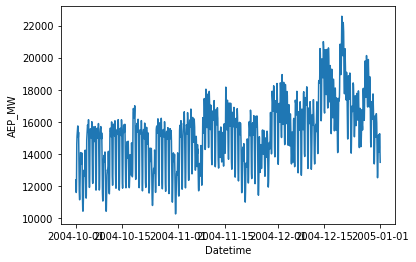

In [7]:
#apenas os primeiros meses
_ = sns.lineplot(x="Datetime", y="AEP_MW", data=df[df.Datetime.dt.date < datetime.date(2005, 1, 1)])

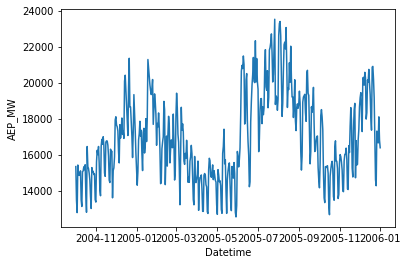

In [8]:
#primeiro ano (e um pouco a mais) às 18:00
_ = sns.lineplot(x="Datetime", y="AEP_MW", data=df[(df.Datetime.dt.date < datetime.date(2006, 1, 1)) & (df.Datetime.dt.hour == 18)])

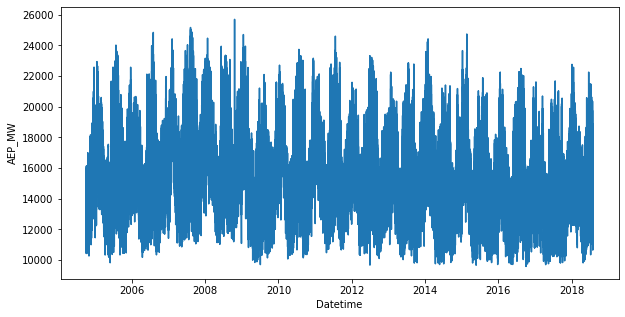

In [9]:
# todo o dataframe pq sim
fig = plt.figure(figsize=(10, 5)) #deixando o plot maior
_ = sns.lineplot(x="Datetime", y="AEP_MW", data=df, figure=fig)

## Tirando noise usando moving average

### Função que cria um novo dataframe com a moving average

In [10]:
def moving_average(df, stride):
  avglist = []
  datelist = []
  startdate = df.Datetime.min()

  while startdate < df.Datetime.max():
    mean_mw = df[(df.Datetime.dt.date >= startdate) & 
              (df.Datetime < startdate+stride)].mean(axis=0)["AEP_MW"]

    avglist.append(mean_mw)
    datelist.append(startdate)

    startdate += stride

  return pd.DataFrame({"AEP_MW":avglist, "Datetime":datelist}, columns=df.columns)

### Moving average semanal durante dois meses

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  


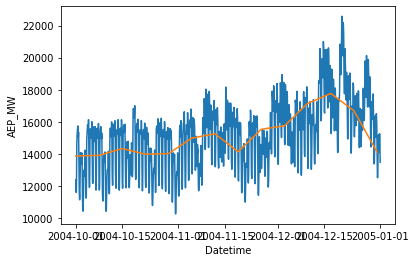

In [11]:
newdf = moving_average(df[df.Datetime.dt.year < 2005], datetime.timedelta(days=7))

_ = sns.lineplot(x="Datetime", y="AEP_MW", data=df[df.Datetime.dt.year < 2005])
_ = sns.lineplot(x="Datetime", y="AEP_MW", data=newdf)

## Predição dos valores de 2015 com os valores de 2014 e 2013 usando moving average

### definindo informação "conhecida" e "não conhecida"

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


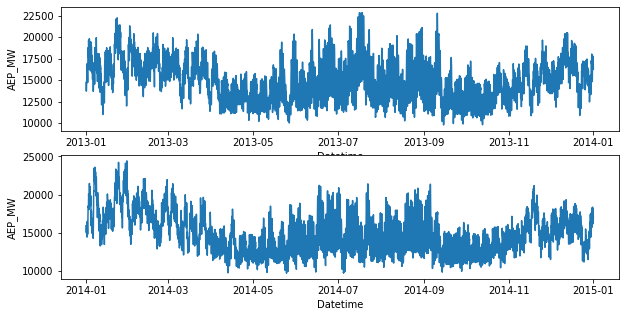

In [12]:
known_data1 = df[df.Datetime.dt.year == 2013]

known_data2 = df[(df.Datetime.dt.year == 2014)]
# anos pares por algum motivo tem um horário a mais (não, não é por ser leap year, 2014 n é)
known_data2.drop(known_data2.tail(1).index,inplace=True)

unknown_data  = df[df.Datetime.dt.year == 2015]

fig, axes = plt.subplots(2, 1, figsize=(10,5))
_ = sns.lineplot(x="Datetime", y="AEP_MW", data=known_data1, ax=axes[0])
_ = sns.lineplot(x="Datetime", y="AEP_MW", data=known_data2, ax=axes[1])

## fazendo as predições

In [13]:
data_trend = pd.DataFrame({"AEP_MW":np.array(known_data2.AEP_MW) - np.array(known_data1.AEP_MW),
                           "Datetime":np.array(known_data1.Datetime)})

data_trend_smooth = moving_average(data_trend, datetime.timedelta(days=30))
data_seasn_smooth = moving_average(known_data2, datetime.timedelta(days=7))

data_correct = data_seasn_smooth.copy()
data_correct.Datetime += datetime.timedelta(days=365)
# n consegui somar direito os valores de data_trend_smooth, as datas zoaram tudo
# ou eu fazia uma predição "quadriculada" repetindo os mesmos valores ou
# as datas proibiam eu de somar os dois, estou aberto a sugestões

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  


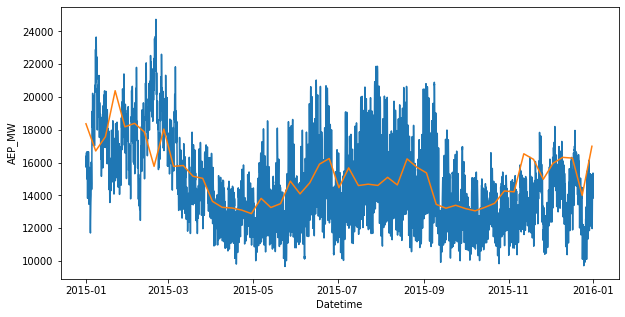

In [14]:
fig = plt.figure(figsize=(10, 5))
_ = sns.lineplot(x="Datetime", y="AEP_MW", data=unknown_data, figure=fig)
_ = sns.lineplot(x="Datetime", y="AEP_MW", data=data_correct, figure=fig)
# não sei se estou fazendo isso certo, mas parece bom já que o padrão está meio sendo seguido
# ainda mais considerando a soma do data_trend_smooth que ficou de fora